<a href="https://colab.research.google.com/github/ghoreishi/Burgers-WEPINN/blob/main/Inviscid_Burgers_WEPINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conservative 1D inviscid Burger's equation**

### $\frac{∂u}{∂t}+\frac{∂u^2/2}{∂x}=0$

$u(0,x) = -sin(π(x-1))$

$u(t,0) = u(t,2) = 0$

In [ ]:
import torch
import numpy as np
import sympy as sp
from torch import nn
import matplotlib.pyplot as plt
torch.use_deterministic_algorithms(True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Define domain

In [ ]:
nx = 100
nt = 100

x = np.linspace(0, 2, nx)
t = np.linspace(0, 1, nt)

epsolin_1 = 0.5
epsilon_2 = 0.5

Adam_it = 5000
LBFGS_it = 0

write_step = 1000

Definition of neural network architecture

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self , Layers , activator = nn.Tanh()):

        super(NeuralNet , self).__init__()

        # Main Neural Network
        # Input Layer
        self.model = nn.ModuleList( [nn.Linear(Layers[0],Layers[1])])

        # Other Layers
        for i in range(1,len(Layers)-1):
            self.model.append(activator)
            self.model.append(nn.Linear(Layers[i],Layers[i+1]))


        # Weight Initializer
        self.model.apply(self.init_weights)

        self.model = self.model.to(device)

    def forward(self , x):  # When Calling The Neural Net
        for layer in self.model:
            x = layer(x)
        return x

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight , gain = 5/3)

Define AD

In [ ]:
def jacv_gen(x , direc):
    jacv = torch.zeros(x.shape , device = device)
    jacv[:,direc] = 1
    return jacv

In [ ]:
from torch.autograd.functional import jvp

def Burgers_EQ_1D(model , xcolloc, epsilon_2):

    global landa, pointwise_Residual
    u = model(xcolloc)
    dudt = jvp(model, xcolloc, v = jacv_gen(xcolloc,0), create_graph=True)[1]
    second_term = lambda x: ((model(x)) **2) / 2
    convection_term = jvp(second_term, xcolloc, v = jacv_gen(xcolloc,1), create_graph=True)[1]
    Div_u = jvp(model, xcolloc, v = jacv_gen(xcolloc,1), create_graph=True)[1]
    landa = 1 / (epsilon_2 * (abs(Div_u) - Div_u) + 1)
    pointwise_Residual = landa[9602:9702] * (dudt[9602:9702] + convection_term[9602:9702])
    Burgers_residual = ( landa * (dudt + convection_term)).pow(2).mean()

    return (Burgers_residual)

Interior points

In [ ]:
import itertools
X_colloc = torch.tensor(list(itertools.product(t[1:],x[1:-1])),dtype=torch.float32).to(device)
#X_colloc = torch.tensor(list(itertools.product(x[1:-1],y[1:-1])),dtype=torch.float32).to(device)

Boundary and Initial Conditions

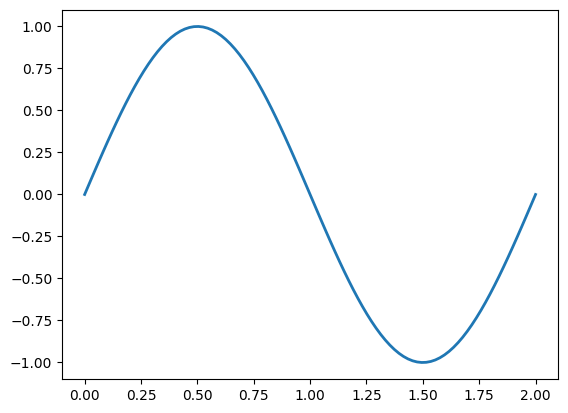

In [ ]:
import math
# Boundary Condition
X_left_bc = list(itertools.product(t[1:],[0.0]))
X_right_bc = list(itertools.product(t[1:],[2.0]))


U_left_bc = np.zeros((nt-1))
U_right_bc = np.zeros((nt-1))


X_bc = np.concatenate((X_left_bc , X_right_bc))
U_bc = np.concatenate((U_left_bc , U_right_bc))

#Initial Condition
X_initial = list(itertools.product([0.0],x))

U_initial = np.zeros((nx))
# print(len(U_initial))

for i in range(nx):
 U_initial[i] = -math.sin(math.pi*(x[i]-1))


fig, axs = plt.subplots()

axs.plot(x, U_initial, linewidth=2.0)


Preparing training data and converting to Torch tensor

In [ ]:
X_train = np.concatenate((X_initial , X_bc)).astype(np.float32)
U_train = np.concatenate((U_initial , U_bc)).astype(np.float32)

X_train = torch.from_numpy(X_train).to(device)
U_train = torch.from_numpy(U_train).to(device)
# print(U_train)


Configuring PINN and its Optimizers

In [ ]:
Layers = [2] + 4*[30] + [1]

PINet = NeuralNet(Layers)

optimizer1 = torch.optim.Adam(PINet.parameters() , lr = 1e-3)
optimizer2 = torch.optim.LBFGS(PINet.parameters() , lr = 1e-1)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1 ,\
                                                        mode = 'min' ,\
                                                        patience = 120, \
                                                        factor = 0.8, \
                                                        threshold = 1e-5,\
                                                        verbose = True)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2 ,\
                                                        mode = 'min' ,\
                                                        patience = 10, \
                                                        factor = 0.1, \
                                                        verbose = True)

Loss Function

In [ ]:
loss_fn = torch.nn.MSELoss()

Closure Definition

In [ ]:
def closure():
  optimizer.zero_grad()
  U_pred = PINet(X_train)

  IB_Loss = epsolin_1 * loss_fn(U_pred[:,0] , U_train)
  PDE_Loss = Burgers_EQ_1D(PINet , X_colloc, epsilon_2)
  total_loss = IB_Loss +  PDE_Loss


  global val_total_loss, val_IB_Loss, val_PDE_Loss

  val_total_loss = total_loss.item()
  val_IB_Loss = IB_Loss.item()
  val_PDE_Loss = PDE_Loss.item()
  total_loss.backward()

  return total_loss

Main Training Loop

In [ ]:
import time
import matplotlib.pyplot as plt

No_epoch = np.array([Adam_it , LBFGS_it]) # Closure (Adams) , L-BFGS

start = time.time()

pointwise_Residual_values = [[] for i in range(int((Adam_it + LBFGS_it)/write_step))]
landa_Values = [[] for i in range(int((Adam_it + LBFGS_it)/write_step))]
total_loss_values = []
PDE_loss_values = []
IB_loss_values = []
epoch_values = []

for epoch in range(No_epoch.sum()):

  if epoch < No_epoch[0]:
    optimizer = optimizer1
    scheduler = scheduler1
  else:
    optimizer = optimizer2
    scheduler = scheduler2

  optimizer.step(closure)
  scheduler.step(val_total_loss)
  total_loss_values.append(val_total_loss)
  PDE_loss_values.append(val_PDE_Loss)
  IB_loss_values.append(val_IB_Loss)
  epoch_values.append(epoch)
  if(epoch%write_step == 0):
    i = int(epoch/write_step)
    pointwise_Residual_values[i] = pointwise_Residual.detach().numpy()
    landa_Values[i] = landa[9602:9702].detach().numpy()
  if(epoch%100 == 0):
    elapsed = time.time() - start
    print("Epoch: ", epoch,"Total_Loss: ", val_total_loss,"IB_Loss:", val_IB_Loss, "PDE_Loss:", val_PDE_Loss, "Time = ", elapsed)
  if(epoch == (No_epoch.sum()-1)):
    print("Epoch: ", epoch,"Loss: ", val_total_loss, "Time = ", elapsed)

Epoch:  0 Total_Loss:  2.3669583797454834 IB_Loss: 0.8076050281524658 PDE_Loss: 1.5593533515930176 Time =  0.09652876853942871
Epoch:  100 Total_Loss:  0.055850956588983536 IB_Loss: 0.051525477319955826 PDE_Loss: 0.004325478803366423 Time =  9.536934614181519
Epoch:  200 Total_Loss:  0.04849177971482277 IB_Loss: 0.04199329763650894 PDE_Loss: 0.0064984834752976894 Time =  18.889763355255127
Epoch:  300 Total_Loss:  0.04131120443344116 IB_Loss: 0.03287098556756973 PDE_Loss: 0.008440220728516579 Time =  27.27168917655945
Epoch:  400 Total_Loss:  0.03574187308549881 IB_Loss: 0.02588709443807602 PDE_Loss: 0.00985478051006794 Time =  36.612579584121704
Epoch:  500 Total_Loss:  0.032619088888168335 IB_Loss: 0.022149639204144478 PDE_Loss: 0.010469449684023857 Time =  46.265249252319336
Epoch:  600 Total_Loss:  0.030614105984568596 IB_Loss: 0.02007451467216015 PDE_Loss: 0.010539591312408447 Time =  55.23490810394287
Epoch:  700 Total_Loss:  0.02906961366534233 IB_Loss: 0.018614284694194794 PDE_

Loss chart

(1e-06, 1)

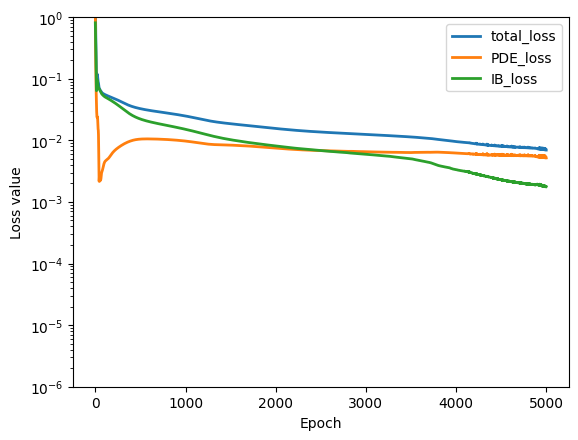

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
X_test = torch.tensor(list(itertools.product(t,x)),dtype=torch.float32).to(device)

y_pred = PINet(X_test)
u_pred = (y_pred).detach().numpy()

ax.plot(epoch_values, total_loss_values, linewidth=2.0)
ax.plot(epoch_values, PDE_loss_values, linewidth=2.0)
ax.plot(epoch_values, IB_loss_values, linewidth=2.0)

plt.xlabel("Epoch")
plt.ylabel("Loss value")
ax.set_yscale('log')
plt.legend(["total_loss", "PDE_loss","IB_loss"], loc ="upper right")
plt.ylim([1e-6, 1])

(-1.0, 2.0)

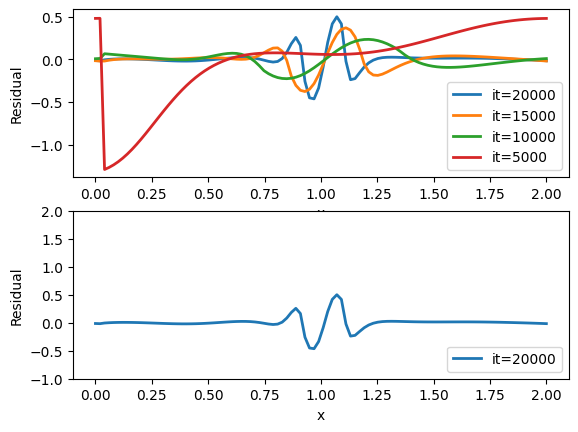

In [ ]:
fig, axs = plt.subplots(2)

axs[0].plot(x, pointwise_Residual_values[3], linewidth=2.0)
axs[0].plot(x, pointwise_Residual_values[2], linewidth=2.0)
axs[0].plot(x, pointwise_Residual_values[1], linewidth=2.0)
axs[0].plot(x, pointwise_Residual_values[0], linewidth=2.0)
axs[0].legend(["it=20000", "it=15000","it=10000","it=5000"], loc ="lower right")
axs[0].set(xlabel='x', ylabel='Residual')

axs[1].plot(x, pointwise_Residual_values[3], linewidth=2.0)
axs[1].legend(["it=20000"], loc ="lower right")
axs[1].set(xlabel='x', ylabel='Residual')

plt.ylim([-1, 2])

(0.0, 1.2)

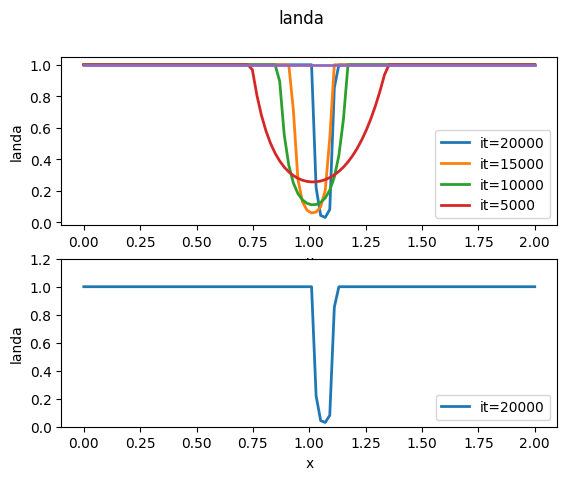

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('landa')

axs[0].plot(x, landa_Values[4], linewidth=2.0)
axs[0].plot(x, landa_Values[3], linewidth=2.0)
axs[0].plot(x, landa_Values[2], linewidth=2.0)
axs[0].plot(x, landa_Values[1], linewidth=2.0)
axs[0].plot(x, landa_Values[0], linewidth=2.0)
axs[0].legend(["it=20000", "it=15000","it=10000","it=5000"], loc ="lower right")
axs[0].set(xlabel='x', ylabel='landa')

axs[1].plot(x, landa_Values[4], linewidth=2.0)
axs[1].legend(["it=20000"], loc ="lower right")
axs[1].set(xlabel='x', ylabel='landa')

plt.ylim([0, 1.2])

(-1.0, 1.0)

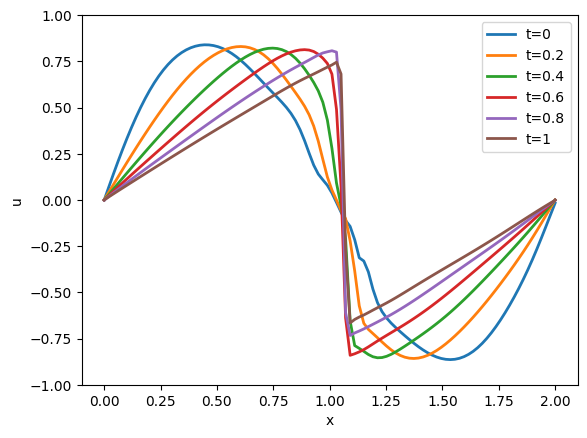

In [ ]:
fig, p = plt.subplots()

p.plot(x, u_pred[0:100], linewidth=2.0)
p.plot(x, u_pred[2000:2100], linewidth=2.0)
p.plot(x, u_pred[4000:4100], linewidth=2.0)
p.plot(x, u_pred[6000:6100], linewidth=2.0)
p.plot(x, u_pred[8000:8100], linewidth=2.0)
p.plot(x, u_pred[9900:10000], linewidth=2.0)

plt.legend(["t=0", "t=0.2","t=0.4","t=0.6", "t=0.8", "t=1"], loc ="upper right")
plt.xlabel("x")
plt.ylabel("u")
plt.ylim([-1,1])

[Text(0.5, 0, 'x'), Text(0, 0.5, 'landa')]

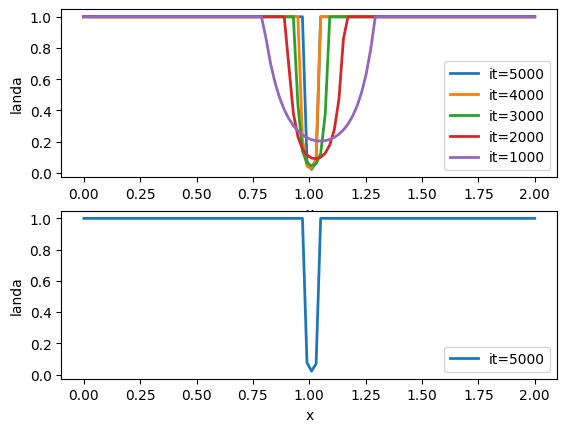

In [ ]:
fig, axs = plt.subplots(2)
# fig.suptitle('landa')

axs[0].plot(x, landa_Values[Adam_it-1][9602:9702], linewidth=2.0)
axs[0].plot(x, landa_Values[4000][9602:9702], linewidth=2.0)
axs[0].plot(x, landa_Values[3000][9602:9702], linewidth=2.0)
axs[0].plot(x, landa_Values[2000][9602:9702], linewidth=2.0)
axs[0].plot(x, landa_Values[1000][9602:9702], linewidth=2.0)
axs[0].legend(["it=5000", "it=4000","it=3000","it=2000","it=1000"], loc ="lower right")
axs[0].set(xlabel='x', ylabel='landa')

axs[1].plot(x, landa_Values[Adam_it-1][9602:9702], linewidth=2.0)
axs[1].legend(["it=5000"], loc ="lower right")
axs[1].set(xlabel='x', ylabel='landa')

# plt.show()

In [ ]:
U_vanillaPINN_Withoutany_Coeff = []
U_vanillaPINN_Withoutany_Coeff = u_pred[9602:9702]

In [ ]:
U_vanillaPINN_Withoutany_epsilon1_01 = []
U_vanillaPINN_Withoutany_epsilon1_01 = u_pred[9602:9702]

In [ ]:
U_vanillaPINN_Withoutany_epsilon1_001 = []
U_vanillaPINN_Withoutany_epsilon1_001 = u_pred[9602:9702]

In [ ]:
U_vanillaPINN_Withoutany_epsilon1_0001 = []
U_vanillaPINN_Withoutany_epsilon1_0001 = u_pred[9602:9702]

(-0.8, 0.8)

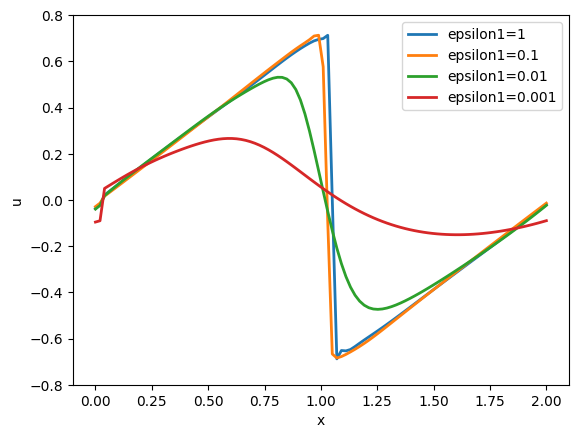

In [ ]:
fig, p = plt.subplots()
p.plot(x, U_vanillaPINN_Withoutany_Coeff, linewidth=2.0)
p.plot(x, U_vanillaPINN_Withoutany_epsilon1_01, linewidth=2.0)
p.plot(x, U_vanillaPINN_Withoutany_epsilon1_001, linewidth=2.0)
p.plot(x, U_vanillaPINN_Withoutany_epsilon1_0001, linewidth=2.0)
#print(P_pred)
plt.xlabel("x")
plt.ylabel("u")
plt.legend(["epsilon1=1", "epsilon1=0.1","epsilon1=0.01","epsilon1=0.001"], loc ="upper right")
plt.ylim([-0.8,0.8])

In [ ]:
U_WEPINN_epsilon1_01_epsilon2_1 = []
U_WEPINN_epsilon1_01_epsilon2_1 = u_pred[9602:9702]

In [ ]:
U_WEPINN_epsilon1_01_epsilon2_01 = []
U_WEPINN_epsilon1_01_epsilon2_01 = u_pred[9602:9702]

In [ ]:
U_WEPINN_epsilon1_01_epsilon2_001 = []
U_WEPINN_epsilon1_01_epsilon2_001 = u_pred[9602:9702]

(-0.8, 0.8)

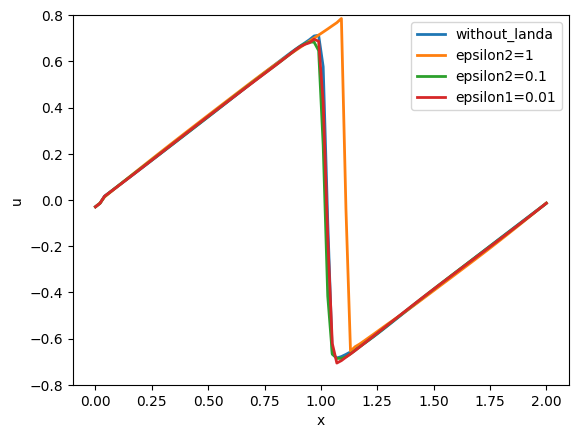

In [ ]:
fig, p = plt.subplots()

p.plot(x, U_vanillaPINN_Withoutany_epsilon1_01, linewidth=2.0)
p.plot(x, U_WEPINN_epsilon1_01_epsilon2_1, linewidth=2.0)
p.plot(x, U_WEPINN_epsilon1_01_epsilon2_01, linewidth=2.0)
p.plot(x, U_WEPINN_epsilon1_01_epsilon2_001, linewidth=2.0)

#print(P_pred)
plt.xlabel("x")
plt.ylabel("u")
plt.legend(["without_landa", "epsilon2=1","epsilon2=0.1","epsilon1=0.01"], loc ="upper right")
plt.ylim([-0.8,0.8])